In [2]:
# import necessary libraries
import spgl1
import numpy as np
from tqdm import tqdm

In [3]:
# Load data
test_data = np.load('test_data.npy')
print(test_data.shape)

(200, 64, 64)


In [9]:
def dct_matrix(n):
    '''Function that outputs an n x n discrete cosine matrix'''
    q = np.arange(n)                      # column indices
    p = np.arange(n)[:, None]             # row indices (as column vector)
    
    dctm = np.sqrt(2/n) * np.cos((p * np.pi * (2*q + 1)) / (2*n))
    dctm[0, :] = 1/np.sqrt(n)             # fix first row separately
    
    return dctm

def CS_pseudo_reconstruction(sample_ratio, full_data, transform_matrix=np.empty(1)):
    '''
    Compressed Sensing (psuedo)reconstruction. This emulates the reconstruction using a fully sampled map and sampling ratio.
    
    Parameters
    ----------
    sample_ratio : int
        Ratio of grid to randomly sample for CS reconstruction
    full_data : array, shape (a, n, n) or (n, n)
        Data to reconstruct. Only make array 2-dim if there is just one input map to reconstruct.
    transform_matrix (Optional) : array, shape (n, n)
        Transform matrix to use in reconstruction. If none is provided, a discrete cosine transform matrix is calculated and used
    
    Returns
    -------
    recon_data : array, shape (a, n, n) or (n, n)
        Reconstructed data.
    '''

    # Check that full_data array is square
    if (full_data.ndim == 3 and full_data.shape[1] != full_data.shape[2]) or (full_data.ndim == 2 and full_data.shape[0] != full_data.shape[1]):
        return "Please make sure full_data array is square"
    
    # Calculate a random sample of points (rnd_positions)
    if full_data.ndim == 3: num_totPoints = full_data.shape[1]*full_data.shape[2]
    elif full_data.ndim == 2: num_totPoints = full_data.shape[0]*full_data.shape[1] 
    
    num_sampPoints = int(num_totPoints*sample_ratio)
    rnd_indicies = np.random.choice(num_totPoints, size=(num_sampPoints), replace=False)
    
    if full_data.ndim == 3: positions = np.indices((full_data.shape[1], full_data.shape[2])).reshape(2, -1).T  # shape → (rows*cols, 2)
    elif full_data.ndim == 2: positions = np.indices((full_data.shape[0], full_data.shape[1])).reshape(2, -1).T  # shape → (rows*cols, 2)
    rnd_positions = positions[rnd_indicies]
    
    if full_data.ndim == 3:
        # Create arr to hold spare sampled data
        sparse_data = np.zeros((full_data.shape[0], full_data.shape[1], full_data.shape[2]))
        for p in rnd_positions:
            sparse_data[:, p[0], p[1]] = full_data[:, p[0], p[1]]

        recon_data = np.zeros((full_data.shape[0], full_data.shape[1], full_data.shape[2]))

        # Create transform matrix
        if transform_matrix == np.empty(1):
            transform_matrix = dct_matrix(full_data.shape[1]*full_data.shape[2])

        # Loop over all samples in input data
        for i in tqdm(range(full_data.shape[0])):
            # Calculate y
            n=0
            y = np.zeros((rnd_positions.shape[0],))
            for p in rnd_positions:
                y[n] = sparse_data[i, p[0],p[1]]
                n+=1
            y -= np.mean(y) # Center y to a mean of 0
        
            rnd_positions_1D = []
            for p in rnd_positions:
                rnd_positions_1D.append(p[1]*full_data.shape[1]+p[0])
        
            # Create sampling matrix
            sampling_mtrx = np.identity(num_totPoints)[rnd_positions_1D, :]

            # Calculate A and alpha
            A = np.matmul(sampling_mtrx, transform_matrix)
            alpha = spgl1.spgl1(A, y, tau=0, sigma=0.0001)
        
            x = np.matmul(transform_matrix, alpha[0])
            recon_data[i, :, :] = np.fliplr(np.rot90(np.reshape(x, (full_data.shape[1], full_data.shape[2])), k=3))
    
        return recon_data

    if full_data.ndim == 2:
        # Create arr to hold spare sampled data
        sparse_data = np.zeros((full_data.shape[0], full_data.shape[1]))
        for p in rnd_positions:
            sparse_data[p[0],p[1]] = full_data[p[0],p[1]]
        
        # Calculate y
        n=0
        y = np.zeros((rnd_positions.shape[0],))
        for p in rnd_positions:
            y[n] = sparse_data[p[0],p[1]]
            n+=1
        y -= np.mean(y) # Center y to a mean of 0
    
        rnd_positions_1D = []
        for p in rnd_positions:
            rnd_positions_1D.append(p[1]*full_data.shape[0]+p[0])
    
        # Create sampling matrix
        sampling_mtrx = np.identity(num_totPoints)[rnd_positions_1D, :]

        # Create transform matrix
        if transform_matrix == np.empty(1):
            transform_matrix = dct_matrix(full_data.shape[0]*full_data.shape[1])

        # Calculate A and alpha
        A = np.matmul(sampling_mtrx, transform_matrix)
        alpha = spgl1.spgl1(A, y, tau=0, sigma=0.0001)

        # Calculate x (1-dim) and reshape + rotation + flip to get reconstructed input data
        x = np.matmul(transform_matrix, alpha[0])
        recon_data = np.fliplr(np.rot90(np.reshape(x, (full_data.shape[0], full_data.shape[1])), k=3))

        return recon_data

In [10]:
recon_data = CS_pseudo_reconstruction(0.2, test_data[0, :, :])

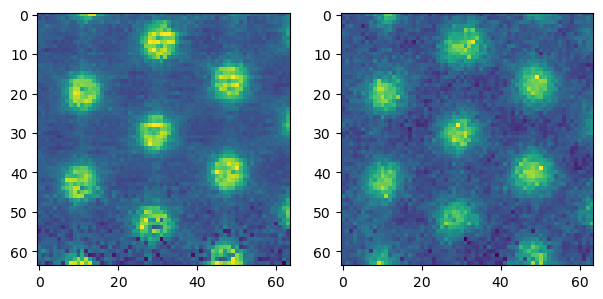

In [13]:
# Plotting example
import matplotlib.pyplot as plt
figure=plt.figure(figsize=(15,10))
ax=figure.add_subplot(141)
ax2=figure.add_subplot(142)
im = ax.imshow(test_data[0]) # Left plot - inputted test data
im = ax2.imshow(recon_data) # Right plot - reconstructed data